In [53]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3 import math
#import model_to_graphviz
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# The seven scientists problem

This problem is from MacKay (2003, p. 309) where it is, among other things,
treated to a Bayesian solution, but not quite using a graphical modeling approach,
nor relying on computational sampling methods.
Seven scientists with wildly-differing experimental skills all make a measurement
of the same quantity. They get the answers x = {−27.020, 3.570, 8.191, 9.898, 9.603,
9.945, 10.056}. Intuitively, it seems clear that the first two scientists are pretty inept
measurers, and that the true value of the quantity is probably just a bit below 10.
The main problem is to find the posterior distribution over the measured quantity,
telling us what we can infer from the measurement. A secondary problem is to infer
something about the measurement skills of the seven scientists.
The graphical model for one way of solving this problem is shown in the Figure below.
The assumption is that all the scientists have measurements that follow a Gaussian
distribution, but with different standard deviations. However, because they are all
measuring the same quantity, each Gaussian has the same mean, and it is just the
standard deviation that differs.

![title](data/sevenscientists.png)

The mean of the Gaussian is $\mu$ and the standard deviation is $\sigma$. Here, the model parameterizes the Gaussian distribution in terms of the mean and precision, not the mean and variance or the mean and standard deviation. These are all simply related, with the variance being $\sigma^{2}$ and the precision being $\lambda = \frac{1}{\sigma^{2}}$.

In [4]:
x = np.array([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])
idx = np.array(list(range(len(x))))


In [25]:
# actually doing it.
with pm.Model() as BenFinegold:
    
    # hyper priors
    mu = pm.Normal("mu", 0, 0.01)
    
    # priors
    lamb = pm.Gamma("lambda", 0.001, 0.01, shape = len(x))
    sigma = pm.Deterministic("sigma", 1/math.sqrt(lamb)) # ??
    
    # likelihood 
    likelihood = pm.Normal("like", mu = mu, sigma = lamb[idx], observed = x)

In [26]:
with BenFinegold: 
    
    # sample stuff
    trace = pm.sample(1000)
    
    # predictive stuff
    post_pred = pm.sample_posterior_predictive(trace, samples = 100)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

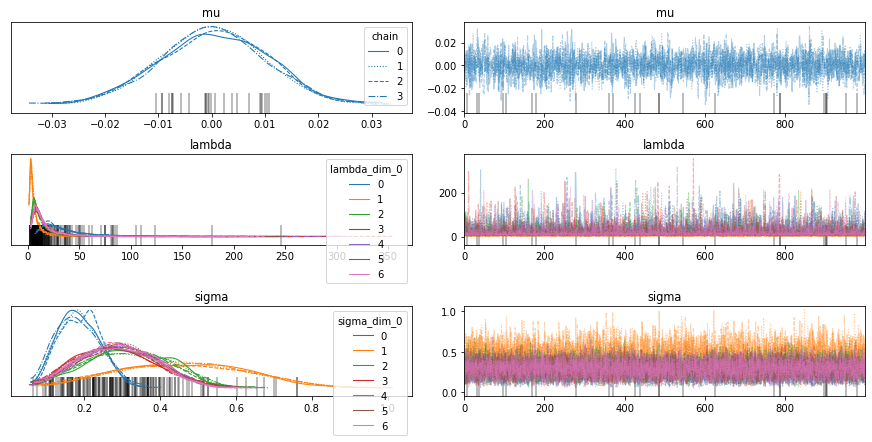

In [27]:
az.plot_trace(trace, legend = True)

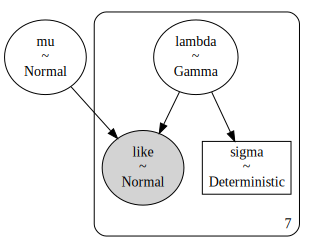

In [23]:
pm.model_to_graphviz(BenFinegold)

# Repeated measurement of IQ

In this example, we consider how to estimate the IQ of a set of people, each of whom
have done multiple IQ tests. The data are the measures xij for the i = 1, . . . , n
people and their j = 1, . . . , m repeated test scores.
We assume that the differences in repeated test scores are distributed as Gaussian
error terms with zero mean and unknown precision. The mean of the Gaussian of
a person’s test scores corresponds to their latent true IQ. This will be different for
each person. The standard deviation of the Gaussians corresponds to the accuracy
of the testing instruments in measuring the one underlying IQ value. We assume
this is the same for every person, since it is conceived as a property of the tests
themselves.
The graphical model for this problem is shown in the figure below. Because we know
quite a bit about the IQ scale, it makes sense to set priors for the mean and standard
deviation using this knowledge. Our first attempt to set priors (these are revisited in
the exercises) simply assume the actual IQ values are equally likely to be anywhere
between 0 and 300, and standard deviations are anywhere between 0 and 100.

![title](data/IQ.png)

In [46]:
y = np.array([[90, 95, 100], [105, 110, 115], [150, 155, 160]])
idx = np.array(list(range(len(y))))

In [44]:
with pm.Model() as G_thang:
    
    sigma = pm.Uniform("sigma", lower = 0, upper = 100)
    mu = pm.Uniform("mu", lower = 0, upper = 300, shape = len(y))
    
    likelihood = pm.Normal("like", mu[idx], sigma = 1/(sigma**2), observed = y)

In [47]:
with pm.Model() as reasonable: 
    
    sigma = pm.HalfNormal("sigma", 15)
    mu = pm.Normal("mu", mu = 100, sd = 30, shape = len(y))
    
    likelihood = pm.Normal("superLike", mu = mu[idx], sigma = sigma, observed = y)

In [48]:
with reasonable: 
    
    trace = pm.sample(draws = 1000, tune = 5000, chains = 4)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 48 seconds.


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

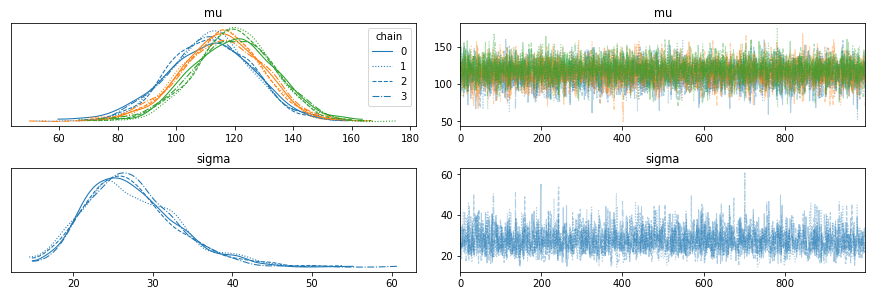

In [51]:
az.plot_trace(trace, legend = True) 

In [54]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],111.695,14.590,83.220,137.974,0.239,0.169,3739.0,3739.0,3763.0,2717.0,1.0
mu[1],115.570,14.278,87.779,141.401,0.222,0.157,4147.0,4147.0,4238.0,2831.0,1.0
mu[2],119.727,13.972,94.793,146.339,0.205,0.145,4627.0,4627.0,4671.0,3064.0,1.0
sigma,27.332,5.885,16.828,38.436,0.113,0.080,2727.0,2727.0,2526.0,1683.0,1.0


In [ ]:
az.plot_trace(G_thang, legend = True)